# Genetic Algorithm

## Abstract

#### Organisms and Genetics
Genetic Algorithms are a form of metaheuristic inspired by the process of natural selection. Before starting, a target is defined that the genetic algorithm ideally gets closer and closer to reaching. Upon starting the genetic algorithm, an initial population of "organisms" are generated. These organisms are a representation of some outcome, each with a set of "genes" or instructions that can be passed on from organism to organism. This population must have a size large enough to support diversity in the population, at least at the beginning. 

#### Fitness
The "fitness" of each organism is then determined by comparing the organism's output with the desired target output. The organisms are sorted from highest to lowest fitness where the fitness is higher the closer the organism is to the desired target. The organisms with the highest fitness have the highest likelihood of "breeding" and passing on their "genetics" to the next batch of organisms, thus rewarding and incentivising the development of increasingly accurate organisms in the population. 


#### Breeding
This process of breeding generally includes two processes: cross-over and mutation. Just as in sexual reproduction, the offspring of two organisms has genes that are the result of a combination of the genes from each parent. In the case of a genetic algorithm, about half of the genetics come from each parent at random. This process of determining the fitness and breeding an organism is repeated until the user is satisfied with the result.

## Introduction

In this project, the goal is to approximate a given image using polygons through genetic algorithms. The population will consist of a number (*POPULATION_SIZE*) of organisms which I will call a "Painter." These Painters will consist of a number (*numGenes*) of shapes with any number of vertices between *MIN_VERTICES* and *MAX_VERTICES*. Each Painter in the population will be sorted by fitness, determined by the inverse of the root-mean-square error (rmse) of the Painter's painting and the target image. The breeding process will then select the partners for breeding by generating a random number and selecting one of the Painters in the population, where the likelihood of selecting the a Painter is lower than that of the Painter with a higher fitness score. The partners would then breed to make a child, each gene being a shape chosen from either parent at random (50% chance from either). For example, the first gene of the child would be either the first gene in parent 1 or parent 2, the second gene from either parent 1 or parent 2, and so on. This process of breeding is repeated until the number of children is the desired *POPULATION_SIZE*. The process is then repeated indefinitely.


In [1]:
# Number Processing
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

## Global Settings

The variables with all capital letters are determined directly by myself. The variables that follow are determined by the variables I define and belong in the global scope of the project.

In [2]:
IMG_SRC = "kissy-face.png"
POPULATION_SIZE = 100
MIN_VERTICES = 3
MAX_VERTICES = 3
MAX_DIST = 30 # The max distance from the first vertex that the other vertices can be (in px)
MIN_VERTEX_SHIFT = 1;
MAX_VERTEX_SHIFT = 10;
MIN_COLOR_SHIFT = 5;
MAX_COLOR_SHIFT = 40;
DECAY = 7/10.0; # The closer this value is to 0, the more the breeding process favors high fitness when selecting partners

# Determines other variables which depend on the variables defined above
target = cv2.imread(IMG_SRC, 1) # 1 for color (including alpha channel), 0 for gray scale
width = w = target.shape[1]
height = h = target.shape[0]
# The number of shapes in each Painter's painting is determined by the Maximum Distance from the first vertex, ideally taking up the whole screen with shapes of at least three points 
numGenes = ( w / MAX_DIST + 1 ) * (h / MAX_DIST + 1) * 4
# The rate of mutation should be relative to the number of genes,
# either 4.0/numGenes or 1/80.0, which ever is greater
MUTATION_RATE = 4.0/numGenes

## Error Functions

These functions aim to determine the error of the rgba values of the real image (an np array) and the Painter's image

#### Average Error

The first function, "error", calculates the average error of each value for red, green, blue, or alpha.  

#### RMSE

The second function, "rmse", calculates the root-mean-squared error, where the difference in squares of the actual value and the experimental values are averaged and then square rooted

In [3]:
# Average Error
def error(actual, experimental):
    return np.absolute(actual-experimental).mean()
# The Root-Mean-Squared Error
def rmse(actual, experimental):
    return np.sqrt( ((actual - experimental)**2).mean() )

## Helper Functions
Making the code more readable


In [ ]:

# returns the angle to the horizontal between the two points, going counter clockwise
def getAngle (point1, point2):
    y = point1[1] - point2[1]
    x = point1[0] - point2[1]
    theta = math.atan(y/x)
    # since math.atan(n) yields a number between pi/2 and -pi/2, I need to adjust the angle
    if (x < 0 and y > 0):
        theta += math.pi
    if (x < 0 and y < 0):
        theta += math.pi
    return theta

## The Shape Class

This class will have an array of vertices and the color of the shape. When initializing, the first point is randomly generated, and from then on, the other vertices must not exceed a specific distance from that first vertex. This is intended to prevent one shape from taking up a vast majority of the screen.

### Mutation Method

#### Changing the Position of the Vertices

To limit the size of the shape, I limited the distance the vertices can be from the shape's first vertex. 

My initial approach to shifting the vertices was to randomize a dx and dy for a given vertex, then check if shifting that amount would make the vertex more than some distance from the first vertex. If so, repeatedly randomize a dx and dy until the distance from the given vertex and the first vertex.

I realized that this could be a source of unnecessary computational time, so instead I will randomize a random angle from $0$ - $2pi$. With this angle the program would determine the maximum distance that the vertex can be shifted in that direction before it exceeds the predetermined distance from the first vertex.

The first vertex will be referenced here after as $v_1$ and the vertex being shifted as $v_s$.

When shifting $v_s$, there will be three known variables beforehand:
$\theta$, which is a generated random value from $0$ - $2pi$,
$r$, which is the maximum distance that $v_s$ can be from the $v_1$, and
$r_1$, which is the current distance between the $v_1$ and $v_s$.


To derive the maximum distance the point can be moved in any given direction, we will construct a right triangle with the generalization that $v_1$ and $v_s$ are horizontal relative to one another. Thus, we can create two right triangles. The first would be the triangle which contains our desired length, $d$, along with the horizontal side length labeled $d_x$ and the vertical labeled $d_y$. The angle between $d$ and $d_x$ is $\theta$ and the point where they intersect is $v_s$. The second right triangle encompasses the first, with side lengths $d_y$ and $(d_x + r_1)$ and hypotenuse of $r$. This can then be written as two equations as follows:

$$
\begin{eqnarray}
r^2 &=& (d_y)^2 &+& (r_1 + d_x)^2 \\
d^2 &=& (d_y)^2 &+& (d_x)^2 \\
\cos\theta &=& \frac{d_x}{d}
\end{eqnarray}
$$

The third equation is a trigonometric equation that can be determined by the second equation.

First we can subtract the second equation from the first to cancel out the $d_y$ and expand the terms, and then substitute the value $d\cdot{\cos\theta}$:

$$
\begin{eqnarray}
r^2 - d^2 &=& -d_x^2 + (r_1 + d_x)^2 \\
0 &=& d^2 - r^2 - d_x^2 + r_1^2 + 2\cdot r_1\cdot d_x + d_x^2 \\
0 &=& d^2 + 2\cdot r_1\cdot d_x + r_1^2 - r^2 \\
0 &=& d^2 + (2\cdot r_1\cdot\cos(\theta))\cdot d + (r_1^2 - r^2)
\end{eqnarray}
$$

Finally, we can use the quadratic formula to solve for $d$:

$$
\begin{eqnarray}
d &=& \frac{-(2\cdot r_1\cdot\cos(\theta))\pm\sqrt{(2\cdot r_1\cdot\cos(\theta))^2-4\cdot(r_1^2-r^2)}}{2} \\
d &=& -(\cdot r_1\cdot\cos(\theta))\pm\sqrt{r_1^2\cdot\cos^2(\theta)-r_1^2+r^2)} \\
d &=& -(\cdot r_1\cdot\cos(\theta))\pm\sqrt{(\cos^2(\theta)-1)\cdot r_1^2+r^2)} \\
d &=& -(\cdot r_1\cdot\cos(\theta))\pm\sqrt{r^2-\sin^2(\theta)\cdot r_1^2}
\end{eqnarray}
$$

In the end, we get the following equation for $d$ in terms of $\theta$, $r$, and $r_1$:

$d\ =\ -\cos\left(\theta\right)\cdot r_1+\sqrt{\left(r^2-\sin^2\left(\theta\right)\cdot r_1^2\right)}$

In [79]:
class Shape:
    def __init__ (self):
        # Randomly generates the number of vertices for this shape
        self.numVertices = np.random.randint(MIN_VERTICES, MAX_VERTICES + 1)
        # Generates a place holder array 
        self.vertices = np.zeros((self.numVertices, 2))
        # The first vertex can begin anywhere
        self.vertices[0] = [np.random.rand()*w, np.random.rand()*h]
        # Randomly generates the other points, and continues to if the vertex is too far from the first
        for i in range(1, self.numVertices):
            theta = np.random.rand() * 2 * math.pi
            dist = np.random.rand() * MAX_DIST
            dx = dist * math.cos(theta)
            dy = dist * math.sin(theta)
            self.vertices[i] = [self.vertices[0, 0] + dx, self.vertices[0, 1] + dy]
            
        
        # Randomizes the color of the Shape
        self.r = np.random.randint(0, 256);
        self.g = np.random.randint(0, 256);
        self.b = np.random.randint(0, 256);
    
    # makes a copy of the shape
    def copy (self):
        c = Shape();
        c.vertices = self.vertices.copy()
        c.r = self.r
        c.g = self.g
        c.b = self.b
        return c
    
    def equals (self, other):
        if(np.sum(self.vertices - other.vertices) != 0):
            return False;
        if(self.r != other.r):
            return False;
        if(self.g != other.g):
            return False;
        if(self.b != other.b):
            return False;
        return True;
    
    # slightly mutates the shape
    def mutate (self):
        
        # Mutates the vertices in the shape first, including the first
        # The amount it shifts the first shifts the others as well
        v0_theta = np.random.rand() * 2 * math.pi
        v0_d = np.random.rand() * MAX_DIST
        v0_dx = v0_d * math.cos(v0_theta)
        v0_dy = v0_d * math.sin(v0_theta)
        # checks if moving the triangle results in any vertex going off screen
        for i in range(self.vertices.shape[0]):
            if self.vertices[i, 0] + v0_dx < 0:
                v0_d = v0_d * (-self.vertices[i, 0]) / v0_dx
                v0_dx = v0_d * math.cos(v0_theta)
                v0_dy = v0_d * math.sin(v0_theta)
            if self.vertices[i, 0] + v0_dx > width:
                v0_d = v0_d * (width-self.vertices[i,0]) / v0_dx
                v0_dx = v0_d * math.cos(v0_theta)
                v0_dy = v0_d * math.sin(v0_theta)
            if self.vertices[i, 1] + v0_dy < 0:
                v0_d = v0_d * (-self.vertices[i, 1]) / v0_dy
                v0_dx = v0_d * math.cos(v0_theta)
                v0_dy = v0_d * math.sin(v0_theta)
            if self.vertices[i, 1] + v0_dy > height:
                v0_d = v0_d * (height-self.vertices[i,1]) / v0_dy
                v0_dx = v0_d * math.cos(v0_theta)
                v0_dy = v0_d * math.sin(v0_theta)
        deltas = np.ones((self.vertices.shape[0], 1)) * np.array([v0_dx, v0_dy])
        self.vertices += deltas 
        
        if self.vertices[0, 0] < 0:
            self.vertices += np.ones((self.vertices.shape[0],1))*np.array([-self.vertices[0, 0], 0])
        if self.vertices[0, 1] < 0:
            self.vertices += np.ones((self.vertices.shape[0],1))*np.array([0, -self.vertices[0, 1]])
        if self.vertices[0, 0] > width:
            self.vertices += np.ones((self.vertices.shape[0],1))*np.array([width-self.vertices[0, 0], 0])
        if self.vertices[0, 1] > height:
            self.vertices += np.ones((self.vertices.shape[0],1))*np.array([0, height-self.vertices[0, 1]])
        
        # now mutates all of the other points
        for i in range(1, self.numVertices):
            # randomly generates an angle
            theta = np.random.rand() * 2 * math.pi
            # determines the distance between this point and the first vertex
            d_1 = np.linalg.norm( self.vertices[i] - self.vertices[0] )
            # determines the angle between the vertices and the horizontal
            d_theta = getAngle(self.vertices[0], self.vertices[i]);
            
            
            # Determines the maximum distance that the point can move in any direction
            max_dist = - math.cos(theta)*d_1 + math.sqrt(MAX_DIST**2-( math.sin(theta) * d_1 )**2)
            if max_dist > MAX_DIST:
                max_dist = MAX_DIST
            # Goes a random amount in the given distance
            d = np.random.rand() * max_dist
            
            # increments the vertex
            self.vertices[i] += [math.cos(theta+d_theta)*d, math.sin(theta+d_theta)*d]
            # restrains the vertices to remain visible
            if self.vertices[i, 0] < 0: # x < 0
                self.vertices[i,0] = 0
            if self.vertices[i, 1] < 0: # y < 0
                self.vertices[i, 1] = 0
            if self.vertices[i, 0] > width:  # x > w
                self.vertices[i,0] = width
            if self.vertices[i, 1] > height: # y > h
                self.vertices[i, 1] = height
            
        # Mutates the colors next
        dr = np.random.choice([-1, 1]) * (np.random.rand() * (MAX_COLOR_SHIFT - MIN_COLOR_SHIFT) + MIN_COLOR_SHIFT);
        dg = np.random.choice([-1, 1]) * (np.random.rand() * (MAX_COLOR_SHIFT - MIN_COLOR_SHIFT) + MIN_COLOR_SHIFT);
        db = np.random.choice([-1, 1]) * (np.random.rand() * (MAX_COLOR_SHIFT - MIN_COLOR_SHIFT) + MIN_COLOR_SHIFT);
        # increment the colors
        self.r += dr
        self.g += dg
        self.b += db
        # Adjust the colors if they are below 0 or above 255
        if self.r < 0:
            self.r = 0
        if self.r > 255:
            self.r = 255
        if self.g < 0:
            self.g = 0
        if self.g > 255:
            self.g = 255
        if self.b < 0:
            self.b = 0
        if self.b > 255:
            self.b = 255
        
    def draw (self, img):
        v = np.int32(self.vertices.reshape((1,) + self.vertices.shape))
        cv2.fillPoly(img, v, (self.r, self.g, self.b))

## The Painter Class

This is the "organism" of the population. It's genetics is represented by an array of Shapes, which are applied onto its personal "canvas." The fitness of the Painter is then determined via the inverse of the rmse. 

In [81]:
class Painter:
    
    def __init__ (self, givenGenetics=False, genetics=None):
        if(not givenGenetics):
            self.genetics = range(numGenes);
            for i in range (numGenes):
                self.genetics[i] = Shape();
            self.genetics = np.array(self.genetics)
        else:
            self.genetics = genetics
        self.canvas = np.zeros((w, h, 3))
        self.fitness = 0;
        self.rmse = 0;
    
    # determines the rmse and fitness of the painter
    def evaluate (self):
        self.rmse = rmse(self.canvas, target)
        self.fitness = 1/self.rmse
        
    def breed (self, partner):
        genes = np.zeros(numGenes, dtype='object');
        # crossing the genetics, where half the genes come from each parent
        for i in range (numGenes):
            genes[i] = np.random.choice([self.genetics[i], partner.genetics[i]]).copy();
            if(np.random.rand() < MUTATION_RATE):
                genes[i].mutate()
        return Painter(givenGenetics=True, genetics=genes);
    
    def paint (self):
        for i in range(numGenes):
            self.genetics[i].draw(self.canvas)
    
    # Displays the Painter's work
    def exhibit (self):
        plt.imshow(cv2.cvtColor(np.uint8(self.canvas), cv2.COLOR_BGR2RGB))
        plt.show()

## Population Class

The population Class handles the initializing of a begining class of Painters, the sorting of the population, and the selection of partners.

In [62]:
class Population:
    def __init__ (self, givenPainters=False, painters=None):
        if(not givenPainters):
            self.painters = np.zeros(POPULATION_SIZE, dtype='object')
            for i in range(POPULATION_SIZE):
                self.painters[i] = Painter();
        else:
            self.painters = painters
        self.sorted = self.painters.copy();
    def sort (self):
        self.sorted = np.zeros(POPULATION_SIZE, dtype='object')
        for i in range(POPULATION_SIZE):
            self.painters[i].paint()
            self.painters[i].evaluate()
            for j in range(POPULATION_SIZE):
                if (self.sorted[j] == 0):
                    self.sorted[j] = self.painters[i]
                    break;
                if(self.painters[i].fitness > self.sorted[j].fitness):
                    temp = self.sorted[j:len(self.sorted) - 1].copy()
                    self.sorted[j+1:] = temp
                    self.sorted[j] = self.painters[i]
                    break;
    
    def showBest(self):
        self.sorted[0].paint();
        self.sorted[0].exhibit();
    
    def getBest(self):
        return self.sorted[0];
    
    def generation (self):
        self.sort()
        nextGen = np.zeros(POPULATION_SIZE, dtype='object')
        # select the first parent
        for i in range(POPULATION_SIZE):
            p1 = np.random.rand();
            for j in range(POPULATION_SIZE+1):
                if p1 > DECAY**j:
                    p1 = self.sorted[j]
                    break;
                if j == POPULATION_SIZE:
                    p1 = self.sorted[-1]
                    break;
            # select the second parent
            p2 = np.random.rand();
            for j in range(POPULATION_SIZE+1):
                if p2 > DECAY**j:
                    p2 = self.sorted[j]
                    break;
                if j == POPULATION_SIZE:
                    p2 = self.sorted[-1]
                    break;
            nextGen[i] = p1.breed(p2);
        self.painters = nextGen
        return self
            

# Testing the Genetic Algoirthm

Generation: 0, RMSE: 141.381379903


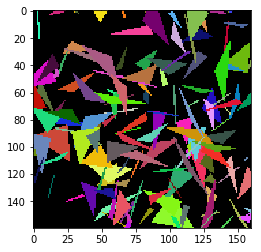

/Users/TomCat/py-image/venv/lib/python2.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: divide by zero encountered in double_scalars


Generation: 50, RMSE: 92.4825447354


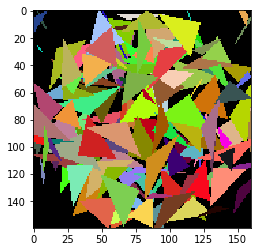

Generation: 100, RMSE: 82.9629523241


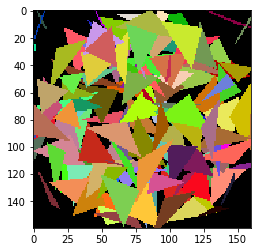

Generation: 150, RMSE: 77.7043035427


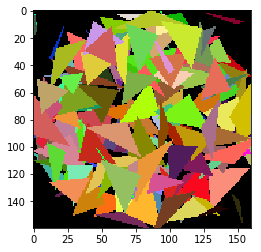

Generation: 200, RMSE: 75.4369207379


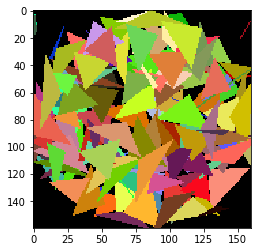

Generation: 250, RMSE: 72.4227950993


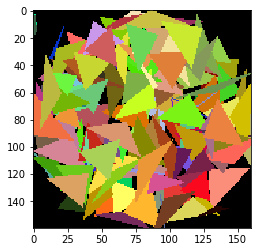

Generation: 300, RMSE: 71.8549913273


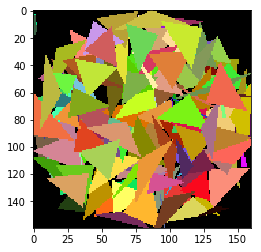

Generation: 350, RMSE: 70.8380518036


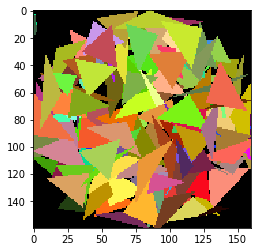

Generation: 400, RMSE: 69.6316008989


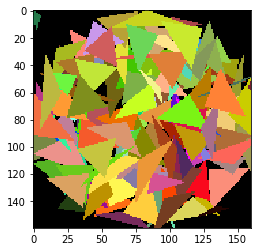

Generation: 450, RMSE: 67.7896250781


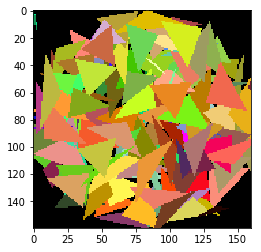

Generation: 500, RMSE: 66.1327164488


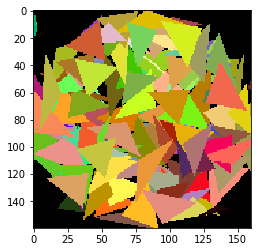

Generation: 550, RMSE: 65.4056308698


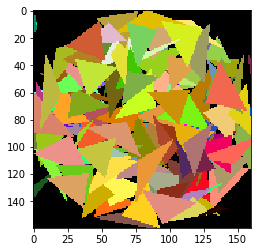

Generation: 600, RMSE: 63.7190677612


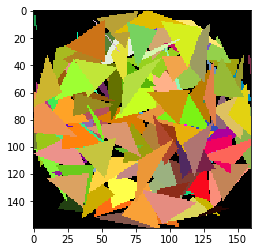

Generation: 650, RMSE: 62.9913530566


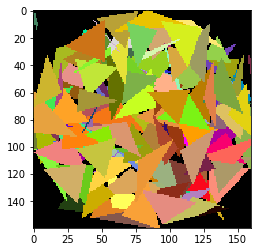

Generation: 700, RMSE: 62.6337251698


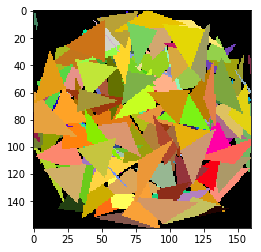

Generation: 750, RMSE: 61.6044532388


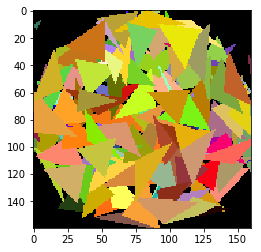

Generation: 800, RMSE: 60.9959843282


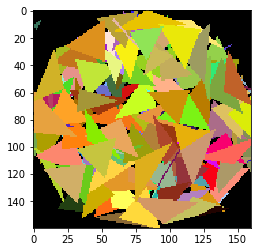

Generation: 850, RMSE: 59.8200107397


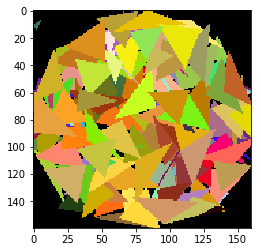

Generation: 900, RMSE: 58.9215727198


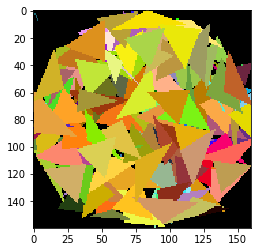

Generation: 950, RMSE: 56.9004961168


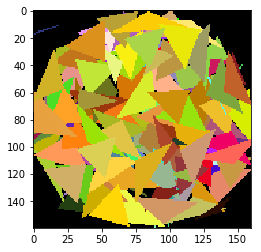

1000


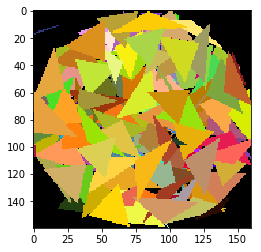

55.7919079454


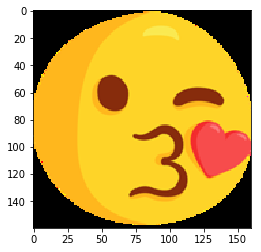

In [84]:
# First seeds the random numbers
np.random.seed(100)
# creates a new Population
p = Population()

num_iter = 1000;

for i in range(num_iter):
    p.generation()
    if i % 50 == 0:
        print '=================================='
        p.getBest().evaluate()
        print "Generation: {}, RMSE: {}".format(i, p.getBest().rmse)
        p.showBest()

        
print num_iter
p.showBest()
p.getBest().evaluate()
print p.getBest().rmse
plt.imshow(cv2.cvtColor(target, cv2.COLOR_BGR2RGB))
plt.show()

# Conclusion

Though this does work, the more detail the image has, the more difficulty the algorithm has in approximating the image using opaque triangles and random genetic variation.

### Future Work
The optimal population size, maximum size of the traingle, and method of selecting mates for breeding could be determined to make the process more effective.
The program could also use some 